# Midterm Assignment, topic 7: Consumer choice model

> The sequence of tasks below should be performed in order in this
notebook. Feel free to add code and markdown cells, but do not change
cells that contain the assignment tasks.
If the task offers some degree of interpretation (so, don’t tell you what
to do exactly), you are free to interpret it in the way you see fit
best. But remember to explain why you make such and such choice in your answer.

> The grade for the midterm assignment is based on both the code
correctness and code style. The former relates to whether the code
adequately represents the economic model under consideration, and the
latter has to do with how well the code is modularized and organized,
whether appropriate syntax is used, and whether the code is well
documented. [PEP 8](https://www.python.org/dev/peps/pep-0008/)
standard is a good reference for coding style, but will not reduce the
grade.

## Modeling consumer choice

In this assignment you consider a classic consumer choice setup given by
the utility function and budget constraint, and numerically derive the
demand function.

Reference: [Hal Varian “Microeconomic analysis”, 3 ed. 1992, Chapter 7, 8](https://books.google.com.au/books/about/Microeconomic_Analysis.html?id=m20iQAAACAAJ&redir_esc=y)

### Task 1. Design and implement a Python class to represent the model

- Use constant elasticity of substitution (CES) utility function to
  represent preferences over two goods  


$$
u(x,y) = \Big( a_1 x^{\frac{s-1}{s}} + a_2 y^{\frac{s-1}{s}} \Big)^{\frac{s}{s-1}}
$$

- Allow prices of the goods be $ p_1 $ and $ p_2 $, and budget
  constraint $ B = x p_1 + y p_2 $.  
- Design the attributes of the class and implement *init* and *repr*
  methods. Implement other methods according to your design.  
- Write a solver for the constraint consumer choice problem as a maximization
  problem in one variable, assuming that no money are wasted.  Use the
  Newton method from week 6 assignment.  Implement all the necessary
  derivative functions as methods of the class.  


Make sure that the derivatives and second derivatives are
working correctly by writing a test that compares numerical derivatives to the analytical ones.
Use the code below written to check a derivative of an arbitrary function,
and write similar code for all other derivatives.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class consumer_choice():

    def __init__(self, p1, p2, budget, a1=0.5, a2=0.5, s=0.5):
        '''Consumer choice model using CES utility.'''
        self.p1,self.p2 = p1,p2
        self.budget = budget
        self.a1,self.a2 = a1,a2
        self.s = s

    def __repr__(self):
        return "CES consumption model with a1={:.2f}, a2={:.2f}, s={:.2f} Prices are p1={:.2f}, p1={:.2f} Budget is B={:.2f}".format(self.a1, self.a2, self.s, self.p1, self.p2, self.budget)

    def y(self, x):
        '''Level of y for given value of x, assuming budget is binding'''
        budget,p1,p2 = self.budget,self.p1,self.p2
        y = budget/p2 - x*p1/p2
        return y

    def ufun(self, x, y):
        '''CES utility function'''
        a1,a2,s = self.a1,self.a2,self.s
        w = (s-1)/s
        u = (a1*x**w + a2*y**w)**(1/w)
        return u

    def foc(self,x):
        '''First order condition for utility maximization'''
        a1,a2,p1,p2,s = self.a1,self.a2,self.p1,self.p2,self.s
        w = (s-1)/s
        return a1*p2*x**(w-1) - a2*p1*self.y(x)**(w-1)

    def dfoc(self,x):
        '''Derivative of the first order condition for utility maximization'''
        a1,a2,p1,p2,s = self.a1,self.a2,self.p1,self.p2,self.s
        w = (s-1)/s
        return (w-1)*( a1*p2*x**(w-2) + a2*p1*self.y(x)**(w-2)*(p1/p2) )

    def solve(self, tol=1e-12, maxiter=100, callback=None):
        '''Newton method to solve for maximum utility
           Callback function arguments (iter,x,x1,err)
        '''
        x = self.budget/self.p1/2 # starting value
        for iter in range(maxiter):
            x1 = x - self.foc(x)/self.dfoc(x)
            err = np.abs(x1-x)
            if callback:
                callback(iter,x,x1,err)
            if err < tol:
                # converged!
                y = self.y(x1)
                u = self.ufun(x1,y)
                return x1, y, u # return the triple of x,y and utility level
            x = x1
        else:
            raise(RuntimeError('Failed to converge, increase maxiter'))

It is always worth checking the code of the derivative when using Newton method.
Modify the test below to check the derivative of the optimality condition.

In [2]:
import unittest
from scipy import optimize

class testsDerivatives(unittest.TestCase):
    """Tests for the bisection function"""

    def test_derivative(self):
        '''test for derivative grad() of function func() over interval (1e-4,100)'''
        grid = np.linspace(1,100,11)
        m = consumer_choice(1,1,10,s=1) # model
        for x in grid:
            self.assertTrue(optimize.check_grad(m.foc,m.dfoc,np.array([x])) < 1e-5)

    # Write your code here

# run the tests
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Task 2. Write a simple function to make contour plots

It should make plots on the $ q_1 $ - $ q_2 $ plane. Use the starter code below

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def contour_plot(fun,xlim=(0,100),ylim=(0,100),ngrid=500,levels=20,title=None):
    '''Function to plot level curves of the supplied fun function of two variables'''
    # create gids for x and y
    xx = np.linspace(xlim[0],xlim[1],ngrid)
    yy = np.linspace(ylim[0],ylim[1],ngrid)
    # combine one-dimensional grids into mesh (two-dimensional grid)
    X,Y = np.meshgrid(xx,yy)
    # compute the function
    Z = fun(X,Y)
    # create levels if asked for number
    if isinstance(levels, int):
        levels = np.linspace(Z.min(),Z.max(),levels)
    # make plot
    cnt = plt.contour(X,Y,Z, vmin=Z.min(), vmax=Z.max(),levels=levels)
    # add title if asked for
    if title:
        plt.title(title)

Test: you should see a nice picture

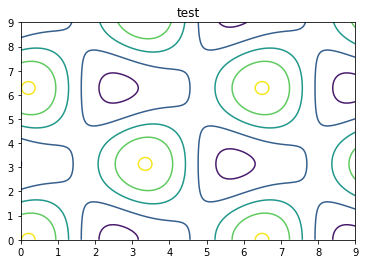

In [4]:
F = lambda x, y: 2.575 - 2*np.cos(x)*np.cos(y+np.pi) - 0.575*np.cos(1.25*np.pi - 2*x)
contour_plot(F, xlim=(0,9), ylim=(0,9), title='test', levels=[1,2,3,4,5])

### Task 3. Add plotting functionality to the model

Make the following plotting functions for the class. To make it possible to overlay different
plots, make sure that plotting methods just add plotted lines to the existing axes, and do not
use plt.show() inside any of the functions.

- Make a *plot_preferences* function which would take the model class as input and
  make a graph to illustrate the preferences. Call the contour_plot() function written
  in Task 2.  
- Make a *plot_budget* function for the class to illustrate the budget of
  the consumer as a single line in the product space.  
- Finally, make *plot_solution* function to illustrate the optimal choice
  with a budget line and the touching indifference curve.  Mark their intersection point
  with a red dot.  

In [5]:
def plot_preferences (model,upper=None,ngrid=500,util=None,show=False):
    '''Draws the contour plots - if no level of utility specified, it will draw 10 levels'''
    # upper bounds for x and y
    if upper:
        xupper = upper
        yupper = upper
    else:
        xupper = model.budget/model.p1+5
        yupper = model.budget/model.p2+5
    # single or multiple indifference curves
    if util:
        lvl = np.array([util])
    else:
        lvl = 10
    contour_plot(model.ufun,xlim=(1e-4,xupper),ylim=(1e-4,yupper),ngrid=ngrid,levels=lvl,title='Indifference curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    if show: plt.show()

def plot_budget (model,ngrid=500,show=False):
    '''Plots the budget line'''
    budget, p1, p2 = model.budget, model.p1, model.p2
    x_space = np.linspace(0, budget/model.p1, ngrid)
    y_space = model.y(x_space)
    plt.plot(x_space, y_space, color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    if show: plt.show()

def plot_solution (model,ngrid=500,show=False):
    '''Plots budget line, and the appropriate indifference curve'''
    x,y,u = model.solve()
    plot_preferences(model,util=u,show=False)
    plot_budget(model,show=False)
    plt.plot(x, y, marker='o', color='green', label='Solution')
    plt.annotate('({:.2f},{:.2f})'.format(x, y), (x+0.5, y+0.5))
    if show: plt.show()

### Task 4. Simple analysis

By drawing several diagrams using your code, illustrate how optimal consumer choice changes with the parameters.

For each of the sets of parameters listed in the table below

- Make a visualization of the utility function  
- Make a diagram of the solution  
- Give economic intuition for the observed differences.  


|Set|$ p_1 $|$ p_2 $|$ B $|$ a_1 $|$ a_2 $|$ s $|
|:--:|:-----------:|:-----------:|:---------:|:-----------:|:-----------:|:---------:|
|A|1.0|1.0|10.0|0.9|0.1|0.5|
|B|1.0|1.0|10.0|0.9|0.1|0.05|
|C|1.0|1.0|10.0|0.9|0.1|1.2|
|D|1.0|3.0|10.0|0.9|0.1|0.5|
|E|1.0|3.0|20.0|0.9|0.1|0.5|

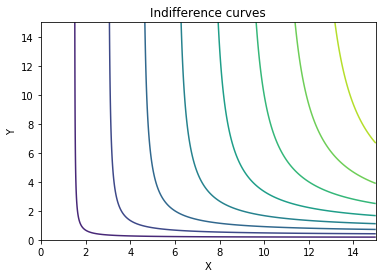

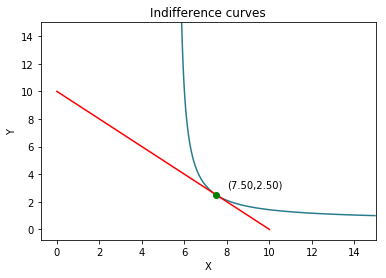

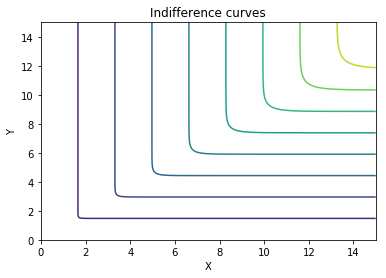

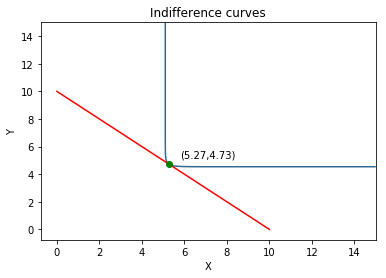

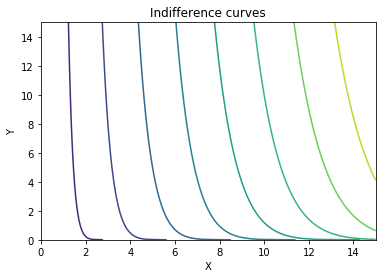

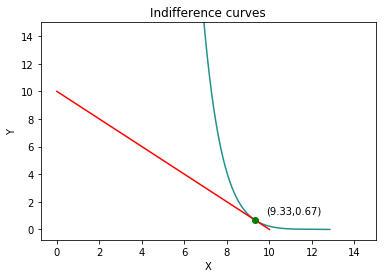

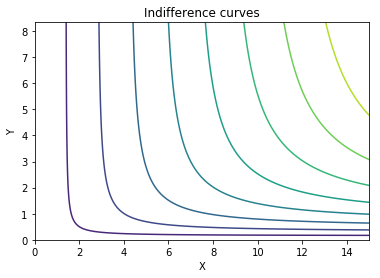

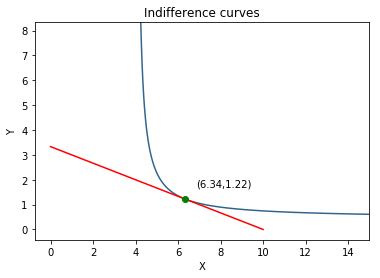

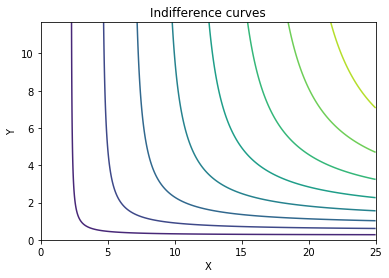

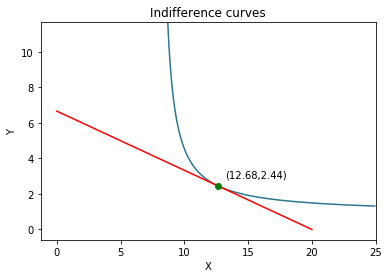

In [6]:
params = [[1.0,1.0,10.0,0.9,0.1,0.5], \
          [1.0,1.0,10.0,0.9,0.1,0.05], \
          [1.0,1.0,10.0,0.9,0.1,1.2], \
          [1.0,3.0,10.0,0.9,0.1,0.5], \
          [1.0,3.0,20.0,0.9,0.1,0.5]]
for p in params:
  model = consumer_choice(*p) # start converts list to parameters
  plot_preferences(model,show=True)
  plot_solution(model,show=True)

### Task 5. Plotting demand

Code up a function which takes a model object as input argument, and creates a series of lines to illustrate
how optimal consumer choice changes with changing prices to give rise to demand curve.

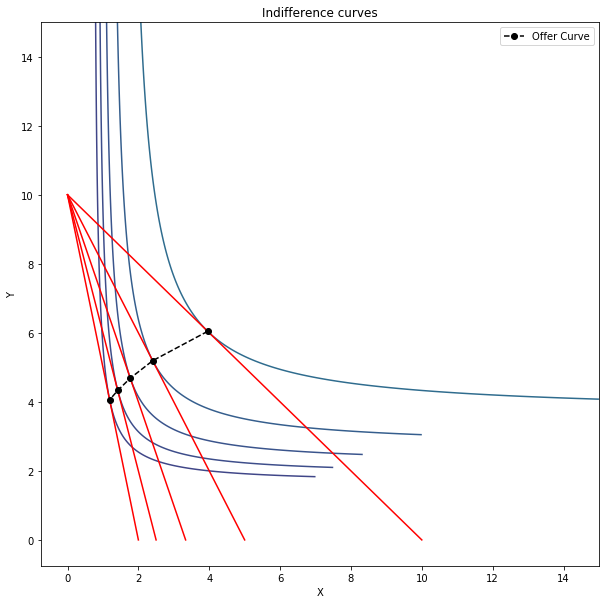

In [7]:
def price_change(model, prices=None):
    '''If a list of prices is provided, plot optimal choices for these prices. Else, plot five price changes on the same graph.'''
    if prices:
        price_space = prices
    else:
        price_space = np.arange(model.p1, model.p1+5)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    x_data, y_data = [], []
    for p in price_space:
        model.p1 = p
        ax = plot_budget(model)
        x,y,u = model.solve()
        x_data.append(x)
        y_data.append(y)
        ax = plot_preferences(model,util=u)
    plt.plot(x_data, y_data, marker='o',ls='dashed', color='black', label='Offer Curve')
    plt.legend()

model = consumer_choice(1,1,10, 0.3, 0.7, 0.5)
price_change(model)
plt.show()

### Task 6. Income effect

Repeat the same exercise for changing budget to illustrate the income effect in consumer choice.

- Decide and argue to either modify the already written function or
  creating a new one.  

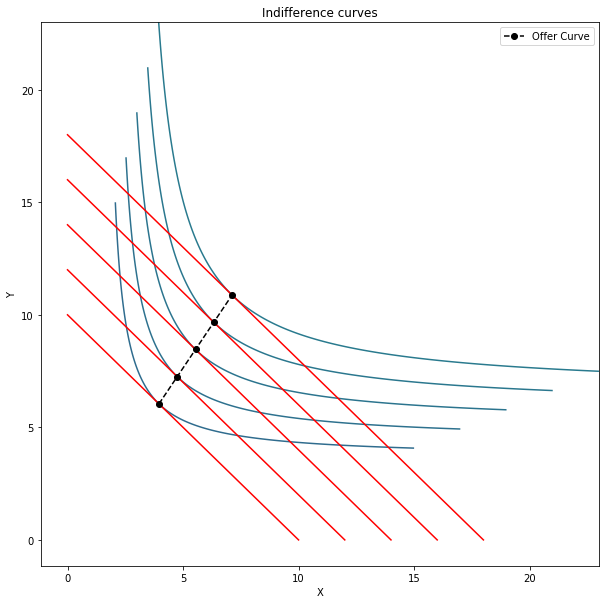

In [8]:
def income_change(model, incomes=None):
    '''If a list of incomes is provided, plot optimal choices for these incomes. Else, plot five price changes on the same graph.'''
    if incomes:
        income_space = incomes
    else:
        income_space = np.arange(model.budget, model.budget+10, 2)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    x_data, y_data = [], []
    for i in income_space:
        model.budget = i
        ax = plot_budget(model)
        x,y,u = model.solve()
        x_data.append(x)
        y_data.append(y)
        ax = plot_preferences(model,util=u)
    plt.plot(x_data, y_data, marker='o',ls='dashed', color='black', label='Offer Curve')
    plt.legend()

model = consumer_choice(1,1,10, 0.3, 0.7, 0.5)
income_change(model)
plt.show()